In [1]:
#| output: false

from __future__ import annotations

import os
import torch
os.environ["KERAS_BACKEND"] = "torch"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from datetime import timedelta
from dateutil.relativedelta import relativedelta
from fastcore import docments
from nbdev.showdoc import show_doc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
df_weekly = pd.read_csv("..\\data\\weekly.csv")
df_monthly = pd.read_csv("..\\data\\monthly.csv")

In [3]:
unnamedCols = [col for col in df_weekly.columns if 'Unnamed' in col]
df_weekly.drop(columns=unnamedCols, inplace=True)
unnamedCols = [col for col in df_monthly.columns if 'Unnamed' in col]
df_monthly.drop(columns=unnamedCols, inplace=True)
df_monthly.drop(columns=['MLA_CLASS'], inplace=True)

In [4]:
df_weekly

,INSTITUTIONCODE,REPORTINGDATE,DESC_NO,ASSET_AMOUNT,LIABILITY_AMT
0,B5114,15.01.10,17.0,0.000000e+00,0.000000e+00
1,B5114,15.01.10,18.0,2.786249e+09,0.000000e+00
2,B5114,15.01.10,19.0,2.511281e+09,0.000000e+00
3,B5114,15.01.10,20.0,2.649853e+08,0.000000e+00
4,B5114,15.01.10,21.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...
821704,Unsampled,01.01.16,13.0,2.418254e+08,0.000000e+00
821705,B5812,01.01.16,12.0,1.059575e+10,1.059575e+10
821706,B5812,01.01.16,11.0,2.133258e+10,2.133258e+10
821707,B5812,01.01.16,10.0,1.490400e+11,1.490400e+11


In [5]:
df_monthly

,INSTITUTIONCODE,BSH_REPORTINGDATE,F001_ASSET_CASH,F002_ASSET_BAL_BOT,F003_ASSET_BAL_BOT_SMR,F004_ASSET_BAL_BOT_CURRENT_ACCOUNT,F005_ASSET_BAL_BOT_OTHERS,F006_ASSET_BAL_OTHER_BANKS,F007_ASSET_BAL_OTHER_BANKS_TZ,F008_ASSET_BAL_OTHER_BANKS_ABROAD,...,EWL_LIQUIDITY RATING,EWAQ_Capital,EWAQ_NPL,EWAQ_GrossLoans,EWAQ_LargeExposures,EWAQ_NPLsNetOfProvisions,EWAQ_NPLsNetOfProvisions2CoreCapital,EWAQ_NPLs2GrossLoans,EWAQ_AssetsQualityRating,EWAQ_Loans
0,B5412,31.01.10,9.570422e+09,5.260077e+10,3.700000e+10,1.560077e+10,0.0,1.350000e+11,1.622160e+10,1.190000e+11,...,1.0,9.514540e+10,1.951219e+09,1.270000e+11,7.137633e+10,903220975.0,0.0095,0.0153,1.0,NaN
1,B5412,28.02.10,6.996645e+09,3.554718e+10,3.200000e+10,3.547185e+09,0.0,1.480000e+11,7.535208e+08,1.470000e+11,...,1.0,9.595342e+10,1.954516e+09,1.250000e+11,7.831967e+10,904869349.0,0.0094,0.0156,1.0,NaN
2,B5412,31.03.10,8.689629e+09,3.744132e+10,3.350000e+10,3.941316e+09,0.0,1.620000e+11,5.570919e+09,1.570000e+11,...,1.0,9.864602e+10,1.979268e+09,1.280000e+11,7.846886e+10,917245663.0,0.0093,0.0154,1.0,NaN
3,B5412,30.04.10,6.811311e+09,3.527009e+10,3.250000e+10,2.770089e+09,0.0,2.240000e+11,8.739334e+09,2.160000e+11,...,1.0,9.960755e+10,2.014398e+09,1.290000e+11,8.986596e+10,934810301.0,0.0094,0.0157,1.0,NaN
4,B5412,31.05.10,9.160128e+09,4.927299e+10,3.982500e+10,9.447986e+09,0.0,1.890000e+11,1.524899e+09,1.880000e+11,...,1.0,1.010000e+11,2.081954e+09,1.320000e+11,8.567217e+10,968588451.0,0.0096,0.0158,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,B5120,31.08.21,6.934755e+08,1.703142e+09,0.000000e+00,1.703142e+09,0.0,2.742275e+08,2.746237e+08,0.000000e+00,...,4.0,9.314589e+10,0.000000e+00,2.274679e+10,1.653192e+10,-5807292.0,-0.0001,0.0000,1.0,NaN
4689,B5120,30.09.21,3.887219e+08,1.388285e+09,0.000000e+00,1.388285e+09,0.0,8.007882e+08,8.035486e+08,0.000000e+00,...,4.0,9.337502e+10,0.000000e+00,2.301912e+10,1.657398e+10,-5749760.0,-0.0001,0.0000,1.0,NaN
4690,B5120,31.10.21,4.772036e+08,7.915250e+08,0.000000e+00,7.915250e+08,0.0,2.992667e+08,3.003208e+08,0.000000e+00,...,4.0,9.359472e+10,0.000000e+00,2.318983e+10,3.300312e+10,-3640727.0,0.0000,0.0000,1.0,NaN
4691,B5120,30.11.21,5.124198e+08,8.769145e+08,0.000000e+00,8.769145e+08,0.0,9.021986e+08,9.052311e+08,0.000000e+00,...,4.0,9.378179e+10,0.000000e+00,2.288809e+10,1.617025e+10,-3554388.0,0.0000,0.0000,1.0,NaN


In [6]:
mask1 = (df_weekly['DESC_NO'] <= 12)
df_weekly['AMOUNT']=np.where(mask1,df_weekly['LIABILITY_AMT'],df_weekly['ASSET_AMOUNT'])
dfX_01 = df_weekly.pivot_table(index=['INSTITUTIONCODE','REPORTINGDATE'], columns=['DESC_NO'], values='AMOUNT')
dfX_01 

DESC_NO                                1.0           2.0           3.0   \
INSTITUTIONCODE REPORTINGDATE                                             
B5014           01.01.16       7.398879e+10  5.628409e+10  9.143355e+10   
                01.01.21       1.795270e+11  6.045049e+10  1.849990e+11   
                01.02.13       2.806429e+10  2.871621e+10  4.605558e+10   
                01.02.19       1.803850e+11  5.977419e+10  1.504990e+11   
                01.03.13       6.784919e+10  2.463718e+10  4.675235e+10   
...                                     ...           ...           ...   
Unsampled       31.08.12       2.701363e+09  1.258243e+10  5.267539e+09   
                31.08.18       4.629424e+09  2.553700e+10  5.334408e+09   
                31.10.14       5.044337e+09  1.529065e+10  7.322940e+09   
                31.12.10       6.763083e+09  3.532561e+10  2.837152e+09   
                31.12.21       8.229725e+09  2.544589e+10  6.746725e+09   

DESC_NO                                4.0           5.0           6.0   \
INSTITUTIONCODE REPORTINGDATE                                             
B5014           01.01.16       2.559228e+08  0.000000e+00  0.000000e+00   
                01.01.21       4.886609e+08  4.961363e+08  0.000000e+00   
                01.02.13       6.198604e+08  0.000000e+00  0.000000e+00   
                01.02.19       1.168116e+09  1.034751e+08  0.000000e+00   
                01.03.13       6.241014e+08  0.000000e+00  0.000000e+00   
...                                     ...           ...           ...   
Unsampled       31.08.12       1.230827e+09  3.191502e+09  4.245538e+07   
                31.08.18       1.142667e+09  2.416068e+09  2.230202e+07   
                31.10.14       1.910804e+09  5.231054e+09  2.308233e+07   
                31.12.10       3.750779e+09  1.038268e+10  0.000000e+00   
                31.12.21       2.541596e+09  1.211769e+10  9.975789e+08   

DESC_NO                               7.0           8.0           9.0   \
INSTITUTIONCODE REPORTINGDATE                                            
B5014           01.01.16               0.0  4.029011e+08  2.570451e+09   
                01.01.21               0.0  3.061811e+08  0.000000e+00   
                01.02.13               0.0  2.773075e+08  3.300202e+09   
                01.02.19               0.0  4.193475e+08  3.272732e+10   
                01.03.13               0.0  3.082848e+08  3.295242e+09   
...                                    ...           ...           ...   
Unsampled       31.08.12               0.0  6.176834e+06  1.104298e+07   
                31.08.18               0.0  6.030663e+06  1.604193e+08   
                31.10.14               0.0  3.032088e+06  1.186188e+07   
                31.12.10               0.0  1.132299e+08  0.000000e+00   
                31.12.21       250000000.0  2.405258e+06  4.273882e+07   

DESC_NO                                10.0  ...          17.0          18.0  \
INSTITUTIONCODE REPORTINGDATE                ...                               
B5014           01.01.16       3.199441e+08  ...  0.000000e+00  1.406108e+10   
                01.01.21       1.431990e+11  ...  0.000000e+00  2.015696e+10   
                01.02.13       8.859703e+08  ...  0.000000e+00  1.586030e+09   
                01.02.19       1.352940e+11  ...  5.635403e+09  7.599516e+09   
                01.03.13       6.371758e+08  ...  0.000000e+00  7.710430e+08   
...                                     ...  ...           ...           ...   
Unsampled       31.08.12       1.127494e+10  ...  0.000000e+00  3.075694e+09   
                31.08.18       2.612991e+10  ...  0.000000e+00  9.280298e+09   
                31.10.14       1.680082e+10  ...  5.295485e+06  5.953266e+09   
                31.12.10       3.417645e+10  ...  0.000000e+00  1.379408e+10   
                31.12.21       1.039779e+10  ...  1.600121e+07  1.639548e+10   

DESC_NO                                19.0 

In [7]:
dfX_01.rename(columns={1: "01_CURR_ACC", 
                    2: "02_TIME_DEPOSIT",
                    3: "03_SAVINGS",
                    4: "04_OTHER_DEPOSITS",
                    5: "05_BANKS_DEPOSITS",
                    6: "06_BORROWING_FROM_PUBLIC",
                    7: "07_INTERBANKS_LOAN_PAYABLE",
                    8: "08_CHEQUES_ISSUED",
                    9: "09_PAY_ORDERS",
                    10:"10_FOREIGN_DEPOSITS_AND_BORROWINGS",
                    11:"11_OFF_BALSHEET_COMMITMENTS",
                    12:"12_OTHER_LIABILITIES",
                    13:"13_CASH",
                    14:"14_CURRENT_ACC",
                    15:"15_SMR_ACC",
                    16:"16_FOREIGN CURRENCY",
                    17:"17_OTHER DEPOSITS",
                    18:"18_BANKS_TZ",
                    19:"19_BANKS_ABROAD",
                    20:"20_CHEQUES_ITEMS_FOR_CLEARING",
                    21:"21_INTERBANK_LOANS",
                    22:"22_TREASURY_BILLS",
                    23:"23_OTHER_GOV_SECURITIES",
                    24:"24_FOREIGN_CURRENCY",
                    25:"25_COMMERCIAL_BILLS",
                    26:"26_PROMISSORY_NOTES"
                    },inplace=True)

In [8]:
dfX_01=dfX_01.reset_index()

In [9]:
dfX_01=dfX_01[(dfX_01['INSTITUTIONCODE']!='Unsampled')&(dfX_01['INSTITUTIONCODE']!=None)]

In [10]:
dfX_01

DESC_NO,INSTITUTIONCODE,REPORTINGDATE,01_CURR_ACC,02_TIME_DEPOSIT,03_SAVINGS,04_OTHER_DEPOSITS,05_BANKS_DEPOSITS,06_BORROWING_FROM_PUBLIC,07_INTERBANKS_LOAN_PAYABLE,08_CHEQUES_ISSUED,...,17_OTHER DEPOSITS,18_BANKS_TZ,19_BANKS_ABROAD,20_CHEQUES_ITEMS_FOR_CLEARING,21_INTERBANK_LOANS,22_TREASURY_BILLS,23_OTHER_GOV_SECURITIES,24_FOREIGN_CURRENCY,25_COMMERCIAL_BILLS,26_PROMISSORY_NOTES
0,B5014,01.01.16,7.398879e+10,5.628409e+10,9.143355e+10,2.559228e+08,0.000000e+00,0.0,0.0,402901067.9,...,0.000000e+00,1.406108e+10,3.927841e+10,-1.727918e+07,2.026688e+10,5.000000e+09,0.000000e+00,2.878479e+10,0.04,0.0
1,B5014,01.01.21,1.795270e+11,6.045049e+10,1.849990e+11,4.886609e+08,4.961363e+08,0.0,0.0,306181140.0,...,0.000000e+00,2.015696e+10,1.692888e+10,4.315962e+07,2.555839e+10,2.550000e+10,1.600000e+10,1.963564e+10,0.00,0.0
2,B5014,01.02.13,2.806429e+10,2.871621e+10,4.605558e+10,6.198604e+08,0.000000e+00,0.0,0.0,277307475.2,...,0.000000e+00,1.586030e+09,1.331957e+10,2.049437e+05,1.137857e+10,3.129665e+10,0.000000e+00,1.079983e+10,-0.01,0.0
3,B5014,01.02.19,1.803850e+11,5.977419e+10,1.504990e+11,1.168116e+09,1.034751e+08,0.0,0.0,419347453.8,...,5.635403e+09,7.599516e+09,5.668946e+08,5.450135e+09,1.130000e+11,2.850000e+10,2.507243e+10,0.000000e+00,0.06,0.0
4,B5014,01.03.13,6.784919e+10,2.463718e+10,4.675235e+10,6.241014e+08,0.000000e+00,0.0,0.0,308284811.6,...,0.000000e+00,7.710430e+08,1.866910e+10,1.958314e+05,5.681760e+09,2.557805e+10,0.000000e+00,1.396014e+10,-0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20342,B5919,31.01.20,3.580831e+09,1.423163e+09,3.291465e+08,0.000000e+00,1.610708e+09,0.0,0.0,0.0,...,0.000000e+00,3.851020e+04,4.205411e+07,6.297477e+06,1.066082e+10,2.600000e+09,0.000000e+00,0.000000e+00,0.00,0.0
20343,B5919,31.05.19,9.871527e+09,1.698387e+09,3.641791e+08,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,5.005318e+08,8.102080e+09,0.000000e+00,0.000000e+00,5.735140e+09,0.000000e+00,1.350651e+08,0.00,0.0
20344,B5919,31.07.20,4.594674e+09,1.647843e+09,4.975718e+08,2.130367e+07,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,3.862709e+04,7.786106e+08,1.512300e+07,5.951239e+09,4.913950e+09,0.000000e+00,0.000000e+00,0.00,0.0
20345,B5919,31.08.18,6.296507e+09,1.425508e+08,1.850541e+08,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,2.487080e+09,5.956955e+09,0.000000e+00,0.000000e+00,4.433260e+09,0.000000e+00,2.274267e+07,0.00,0.0


#1.6 transformed dataset to include computed variables with XX prefix
#transform
def totalDeposits(f01, f02, f03, f04):
  return f01 + f02 + f03 + f04
def totalLiquidLiab(f01,f05, f06, f07, f08, f09, f10, f11, f12):
  return f01 + f05 + f06 + f07 + f08 + f09 + f10 + f11 + f12
def botBalance(f14, f15,f16,f17):
  return f14 + f15 + f16 + f17
def balOtherBanks(f18,f19):
  return f18+f19
def totalLiqAssets(f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26):
  return f13 + f14 + f15 + f16 + f17 + f18 + f19 + f20 + f21 + f22 + f23 + f24 + f25 + f26

dfX_01['XX_CUSTOMER_DEPOSITS'] =dfX_01.apply(lambda x: totalDeposits(x['01_CURR_ACC'],x['02_TIME_DEPOSIT'],x['03_SAVINGS'],x['04_OTHER_DEPOSITS']), axis=1 )
dfX_01['XX_TOTAL_LIQUID_LIAB']=dfX_01.apply(lambda x: totalLiquidLiab(x['XX_CUSTOMER_DEPOSITS'],
                                                                         x['05_BANKS_DEPOSITS'],
                                                                         x['06_BORROWING_FROM_PUBLIC'],
                                                                         x['07_INTERBANKS_LOAN_PAYABLE'],
                                                                         x['08_CHEQUES_ISSUED'],
                                                                         x['09_PAY_ORDERS'],
                                                                         x['10_FOREIGN_DEPOSITS_AND_BORROWINGS'],
                                                                         x['11_OFF_BALSHEET_COMMITMENTS'],
                                                                         x['12_OTHER_LIABILITIES']), axis=1 )
dfX_01['XX_BOT_BALANCE']=dfX_01.apply(lambda x: botBalance(x['14_CURRENT_ACC'], x['15_SMR_ACC'], x['16_FOREIGN CURRENCY'], x['17_OTHER DEPOSITS']),axis=1)
dfX_01['XX_BAL_IN_OTHER_BANKS']=dfX_01.apply(lambda x: balOtherBanks(x['18_BANKS_TZ'],x['19_BANKS_ABROAD']),axis =1)
dfX_01['XX_TOTAL_LIQUID_ASSET']=dfX_01.apply(lambda x: totalLiqAssets(x["13_CASH"],
                                                                      x["14_CURRENT_ACC"],
                                                                      x["15_SMR_ACC"],
                                                                      x["16_FOREIGN CURRENCY"],
                                                                      x["17_OTHER DEPOSITS"],
                                                                      x["18_BANKS_TZ"],
                                                                      x["19_BANKS_ABROAD"],
                                                                      x["20_CHEQUES_ITEMS_FOR_CLEARING"],
                                                                      x["21_INTERBANK_LOANS"],
                                                                      x["22_TREASURY_BILLS"],
                                                                      x["23_OTHER_GOV_SECURITIES"],
                                                                      x["24_FOREIGN_CURRENCY"],
                                                                      x["25_COMMERCIAL_BILLS"],
                                                                      x["26_PROMISSORY_NOTES"]), axis=1)
dfX_01['XX_MLA'] = dfX_01.apply(lambda x: (100 * x['XX_TOTAL_LIQUID_ASSET']/x['XX_TOTAL_LIQUID_LIAB']), axis = 1)



In [11]:
list_columns = dfX_01.columns.tolist()
list_columns.remove("INSTITUTIONCODE")
list_columns.remove("REPORTINGDATE")

In [12]:
df_weekly = dfX_01.pivot_table(index=['REPORTINGDATE'], columns=['INSTITUTIONCODE'], values=list_columns, aggfunc=np.max)

df_weekly.columns = df_weekly.columns.map('_'.join).str.strip('_')
df_weekly = df_weekly.reset_index()

C:\Users\jqb_p\AppData\Local\Temp\ipykernel_15372\360839095.py:1: FutureWarning: The provided callable <function max at 0x000002A342FA1260> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_weekly = dfX_01.pivot_table(index=['REPORTINGDATE'], columns=['INSTITUTIONCODE'], values=list_columns, aggfunc=np.max)


In [13]:
df_weekly

,REPORTINGDATE,01_CURR_ACC_B5014,01_CURR_ACC_B5015,01_CURR_ACC_B5016,01_CURR_ACC_B5018,01_CURR_ACC_B5114,01_CURR_ACC_B5115,01_CURR_ACC_B5116,01_CURR_ACC_B5117,01_CURR_ACC_B5120,...,26_PROMISSORY_NOTES_B5813,26_PROMISSORY_NOTES_B5814,26_PROMISSORY_NOTES_B5815,26_PROMISSORY_NOTES_B5818,26_PROMISSORY_NOTES_B5912,26_PROMISSORY_NOTES_B5913,26_PROMISSORY_NOTES_B5914,26_PROMISSORY_NOTES_B5916,26_PROMISSORY_NOTES_B5917,26_PROMISSORY_NOTES_B5919
0,01.01.16,7.398879e+10,2.699450e+12,1.181293e+10,2.878472e+10,5.296563e+10,5.306420e+11,2.697344e+10,8.259471e+09,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,01.01.21,1.795270e+11,3.511600e+12,9.129312e+09,2.733431e+10,3.076274e+10,6.461520e+11,2.887055e+10,6.029543e+09,301260297.2,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2,01.02.13,2.806429e+10,2.017770e+12,3.627765e+09,1.018729e+10,3.518614e+10,5.180540e+11,1.389488e+10,3.073519e+09,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,01.02.19,1.803850e+11,3.151210e+12,1.359543e+10,7.199220e+10,3.221696e+10,5.902960e+11,2.807409e+10,9.265231e+09,35985536.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01.03.13,6.784919e+10,2.206580e+12,3.885655e+09,8.424048e+09,3.618657e+10,5.310720e+11,1.410214e+10,3.096641e+09,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,31.08.12,5.742916e+10,1.997820e+12,4.600464e+09,2.056301e+09,3.527550e+10,5.549420e+11,1.285742e+10,3.931889e+09,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
621,31.08.18,1.426120e+11,2.929060e+12,1.361314e+10,3.769342e+10,4.007399e+10,5.974350e+11,2.896748e+10,7.718962e+09,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,31.10.14,7.434674e+10,2.419520e+12,8.804305e+09,1.824357e+10,4.330427e+10,5.627170e+11,2.292160e+10,2.882491e+10,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
623,31.12.10,3.839715e+10,1.150740e+12,2.407384e+09,NaN,2.811263e+10,4.247830e+11,1.193679e+10,5.431271e+09,NaN,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN


In [14]:
list_columns = df_monthly.columns.tolist()
list_columns.remove("INSTITUTIONCODE")
list_columns.remove("BSH_REPORTINGDATE")

In [15]:
df_monthly = df_monthly.pivot_table(index=['BSH_REPORTINGDATE'], columns=['INSTITUTIONCODE'], values=list_columns, aggfunc=np.max)
df_monthly.columns = df_monthly.columns.map('_'.join).str.strip('_')
df_monthly = df_monthly.reset_index()

C:\Users\jqb_p\AppData\Local\Temp\ipykernel_15372\2384730024.py:1: FutureWarning: The provided callable <function max at 0x000002A342FA1260> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_monthly = df_monthly.pivot_table(index=['BSH_REPORTINGDATE'], columns=['INSTITUTIONCODE'], values=list_columns, aggfunc=np.max)


In [16]:
df_monthly

,BSH_REPORTINGDATE,DR_B5014,DR_B5015,DR_B5016,DR_B5018,DR_B5114,DR_B5115,DR_B5116,DR_B5117,DR_B5120,...,MLA_B5813,MLA_B5814,MLA_B5815,MLA_B5818,MLA_B5912,MLA_B5913,MLA_B5914,MLA_B5916,MLA_B5917,MLA_B5919
0,28.02.10,6.163333,6.163333,6.163333,NaN,6.163333,6.163333,6.163333,6.163333,NaN,...,61.92,67.54,48.14,NaN,35.73,36.34,35.66,24.79,NaN,NaN
1,28.02.11,5.966667,5.966667,5.966667,NaN,5.966667,5.966667,5.966667,5.966667,NaN,...,63.30,52.02,41.79,NaN,36.75,57.15,38.88,28.53,5395.61,NaN
2,28.02.13,8.896667,8.896667,8.896667,8.896667,8.896667,8.896667,8.896667,8.896667,NaN,...,49.97,38.31,39.53,NaN,30.83,42.68,45.36,21.38,66.63,NaN
3,28.02.14,8.753333,8.753333,8.753333,8.753333,8.753333,8.753333,8.753333,8.753333,NaN,...,52.25,51.29,32.39,132.69,38.85,36.56,32.59,25.75,62.53,NaN
4,28.02.15,8.563333,8.563333,8.563333,8.563333,8.563333,8.563333,8.563333,8.563333,NaN,...,58.39,44.36,29.08,40.13,34.23,36.79,39.85,21.45,50.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,31.12.17,9.660000,9.660000,9.660000,9.660000,9.660000,9.660000,9.660000,9.660000,NaN,...,56.79,41.63,50.79,29.95,35.16,28.20,40.17,20.61,50.47,NaN
140,31.12.18,7.760000,7.760000,7.760000,7.760000,7.760000,7.760000,7.760000,7.760000,7.760000,...,54.20,54.35,40.79,32.94,26.00,27.14,39.15,6.63,28.54,108.75
141,31.12.19,6.790000,6.790000,6.790000,6.790000,6.790000,6.790000,6.790000,6.790000,6.790000,...,46.58,37.59,34.25,NaN,25.75,25.76,34.90,NaN,24.72,53.62
142,31.12.20,6.780000,6.780000,6.780000,6.780000,6.780000,6.780000,6.780000,6.780000,6.780000,...,50.21,29.13,22.60,NaN,22.06,32.37,28.69,NaN,51.26,32.54


In [17]:
df_weekly.fillna(0, inplace=True)
df_monthly.fillna(0, inplace=True)

In [18]:
df_weekly['REPORTINGDATE'] = pd.to_datetime(df_weekly['REPORTINGDATE'])

C:\Users\jqb_p\AppData\Local\Temp\ipykernel_15372\2136419804.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_weekly['REPORTINGDATE'] = pd.to_datetime(df_weekly['REPORTINGDATE'])


In [19]:
df_monthly['BSH_REPORTINGDATE'] = pd.to_datetime(df_monthly['BSH_REPORTINGDATE'])

C:\Users\jqb_p\AppData\Local\Temp\ipykernel_15372\87189534.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_monthly['BSH_REPORTINGDATE'] = pd.to_datetime(df_monthly['BSH_REPORTINGDATE'])


In [20]:
df_weekly = df_weekly.sort_values('REPORTINGDATE')
df_monthly = df_monthly.sort_values('BSH_REPORTINGDATE')

In [21]:
df_weekly_test = df_weekly[df_weekly['REPORTINGDATE'].dt.year>=2019]
df_weekly_train = df_weekly[df_weekly['REPORTINGDATE'].dt.year<2019]

df_monthly_test = df_monthly[df_monthly['BSH_REPORTINGDATE'].dt.year>=2019]
df_monthly_train = df_monthly[df_monthly['BSH_REPORTINGDATE'].dt.year<2019]

In [22]:
df_weekly_test = df_weekly_test.set_index('REPORTINGDATE')
df_weekly_train = df_weekly_train.set_index('REPORTINGDATE')

df_monthly_test = df_monthly_test.set_index('BSH_REPORTINGDATE')
df_monthly_train = df_monthly_train.set_index('BSH_REPORTINGDATE')

In [23]:
df_weekly_train

,01_CURR_ACC_B5014,01_CURR_ACC_B5015,01_CURR_ACC_B5016,01_CURR_ACC_B5018,01_CURR_ACC_B5114,01_CURR_ACC_B5115,01_CURR_ACC_B5116,01_CURR_ACC_B5117,01_CURR_ACC_B5120,01_CURR_ACC_B5213,...,26_PROMISSORY_NOTES_B5813,26_PROMISSORY_NOTES_B5814,26_PROMISSORY_NOTES_B5815,26_PROMISSORY_NOTES_B5818,26_PROMISSORY_NOTES_B5912,26_PROMISSORY_NOTES_B5913,26_PROMISSORY_NOTES_B5914,26_PROMISSORY_NOTES_B5916,26_PROMISSORY_NOTES_B5917,26_PROMISSORY_NOTES_B5919
REPORTINGDATE,,,,,,,,,,,,,,,,,,,,,
2010-01-10,3.143789e+10,1.063160e+12,2.201894e+09,0.000000e+00,2.439812e+10,3.692120e+11,1.347164e+10,6.277640e+09,0.0,7.178594e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-15,3.991095e+10,9.937770e+11,1.757260e+09,0.000000e+00,2.203312e+10,3.686790e+11,1.003941e+10,2.002409e+09,0.0,7.019986e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-22,4.080184e+10,1.110800e+12,1.716277e+09,0.000000e+00,2.257540e+10,3.793080e+11,9.584818e+09,2.189069e+09,0.0,7.599629e+10,...,0.0,9755200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-29,3.765654e+10,1.098480e+12,1.716849e+09,0.000000e+00,2.235771e+10,3.617170e+11,8.528367e+09,3.217120e+09,0.0,6.856952e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-04,4.747060e+10,1.050440e+12,1.960286e+09,0.000000e+00,2.137728e+10,3.519170e+11,1.064651e+10,3.062542e+09,0.0,7.497356e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,1.256420e+11,3.113610e+12,1.544642e+10,3.466770e+10,4.241746e+10,5.341510e+11,2.443348e+10,8.278774e+09,0.0,2.778940e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-10,1.376710e+11,2.867890e+12,1.248563e+10,3.784042e+10,3.418017e+10,6.310340e+11,2.348034e+10,8.777349e+09,0.0,2.877770e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-14,1.819180e+11,3.058840e+12,1.365168e+10,7.207465e+10,3.500164e+10,5.874240e+11,2.842790e+10,8.680415e+09,0.0,2.804400e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_monthly_test

,DR_B5014,DR_B5015,DR_B5016,DR_B5018,DR_B5114,DR_B5115,DR_B5116,DR_B5117,DR_B5120,DR_B5213,...,MLA_B5813,MLA_B5814,MLA_B5815,MLA_B5818,MLA_B5912,MLA_B5913,MLA_B5914,MLA_B5916,MLA_B5917,MLA_B5919
BSH_REPORTINGDATE,,,,,,,,,,,,,,,,,,,,,
2019-01-31,7.640000,7.640000,7.640000,7.640000,7.640000,7.640000,7.640000,7.640000,7.640000,7.640000,...,53.38,48.47,43.04,30.83,26.51,25.20,43.00,6.43,29.34,101.83
2019-02-28,7.520000,7.520000,7.520000,7.520000,7.520000,7.520000,7.520000,7.520000,7.520000,7.520000,...,53.31,50.40,35.14,42.10,27.30,23.43,37.59,4.19,29.57,89.39
2019-03-31,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,...,50.91,49.46,36.74,21.02,25.62,26.00,35.06,5.22,25.74,70.43
2019-04-30,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,...,48.05,43.93,39.07,26.24,25.48,25.34,34.26,0.00,29.46,84.59
2019-05-31,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,...,49.67,46.56,32.32,30.80,24.40,22.10,37.08,0.00,48.20,69.06
2019-06-30,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,7.400000,...,48.18,36.51,35.10,32.18,31.00,26.25,37.23,0.00,58.27,61.24
2019-07-31,7.266667,7.266667,7.266667,7.266667,7.266667,7.266667,7.266667,7.266667,7.266667,7.266667,...,49.19,36.34,36.45,33.41,27.46,24.35,39.93,0.00,61.43,58.42
2019-08-31,7.133333,7.133333,7.133333,7.133333,7.133333,7.133333,7.133333,7.133333,7.133333,7.133333,...,49.02,37.24,34.64,30.46,26.46,26.06,43.45,0.00,33.77,56.60
2019-09-30,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,48.64,35.71,36.02,29.48,25.40,23.34,37.72,0.00,51.15,58.29


# Preprocessing of monthly (df_monthly_xxx) and weekly (df_weekly_xxx) datasets finished, let's feed them into TFT

In [25]:
import numpy as np
import pandas as pd
from TFT import TFT

In [26]:
tft = TFT(cache_data=False, 
          fit_args={'epochs': 20, 'batch_size': 5, 'shuffle': True}
         )


In [27]:
help(TFT)

Help on class TFT in module TFT:

class TFT(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin)
 |  TFT(name='TFT-MF', d_model: int = 8, n_head: int = 1, quantiles: list = [0.1, 0.5, 0.9], lags: dict = {'YE': 1, 'QE': 4, 'ME': 12, 'W': 52, 'D': 365}, tscv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None), compile_args={'optimizer': <keras.src.backend.torch.optimizers.torch_adam.Adam object at 0x000002A35F4BB800>}, fit_args={'epochs': 2, 'batch_size': 10, 'shuffle': True, 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x000002A3621BD640>]}, cache_data=True, cache_model=False, verbose=True)
 |
 |  Method resolution order:
 |      TFT
 |      sklearn.base.BaseEstimator
 |      sklearn.utils._estimator_html_repr._HTMLDocumentationLinkMixin
 |      sklearn.utils._metadata_requests._MetadataRequester
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, name='TFT-MF', d_model: int =

In [28]:
filter_col = [col for col in df_monthly_test if col.startswith('MLA_')]
filter_col

['MLA_B5014',
 'MLA_B5015',
 'MLA_B5016',
 'MLA_B5018',
 'MLA_B5114',
 'MLA_B5115',
 'MLA_B5116',
 'MLA_B5117',
 'MLA_B5120',
 'MLA_B5213',
 'MLA_B5215',
 'MLA_B5216',
 'MLA_B5219',
 'MLA_B5318',
 'MLA_B5319',
 'MLA_B5412',
 'MLA_B5413',
 'MLA_B5417',
 'MLA_B5418',
 'MLA_B5512',
 'MLA_B5515',
 'MLA_B5516',
 'MLA_B5613',
 'MLA_B5619',
 'MLA_B5716',
 'MLA_B5717',
 'MLA_B5719',
 'MLA_B5812',
 'MLA_B5813',
 'MLA_B5814',
 'MLA_B5815',
 'MLA_B5818',
 'MLA_B5912',
 'MLA_B5913',
 'MLA_B5914',
 'MLA_B5916',
 'MLA_B5917',
 'MLA_B5919']

In [29]:
dict_df_y_test={}
dict_df_y_train={}
for mla_name in filter_col:
    df_y_test=df_monthly_test.pop(mla_name)
    df_y_train=df_monthly_train.pop(mla_name)
    df_y_train=pd.DataFrame(df_y_train)
    df_y_test=pd.DataFrame(df_y_test)
    # FIX THIS LATER: it should be from last "_", not last 5 characters
    dict_df_y_test[mla_name[-5:]] = df_y_test
    dict_df_y_train[mla_name[-5:]] = df_y_train
    

In [30]:
dict_df_y_train['B5413']

,MLA_B5413
BSH_REPORTINGDATE,
2010-01-31,39.47
2010-02-28,39.24
2010-03-31,39.92
2010-04-30,40.50
2010-05-31,41.35
...,...
2018-08-31,21.57
2018-09-30,22.71
2018-10-31,20.14


In [31]:
new_cols = [c.replace(".","_").replace(" ","_") for c in df_monthly_train.columns.tolist()]
df_monthly_train = df_monthly_train.set_axis(new_cols, axis=1)

new_cols = [c.replace(".","_").replace(" ","_") for c in df_monthly_test.columns.tolist()]
df_monthly_test = df_monthly_test.set_axis(new_cols, axis=1)

In [32]:
[c for c in df_monthly_train.columns.tolist() if " " in c]

[]

In [33]:
tft.fit(
    X={"W": df_weekly_train, "ME": df_monthly_train},
    y={"ME": dict_df_y_train['B5413']}
)

Processing `X` and `y` data.
  working out the frequencies...
  calculating ...
Processing `X` and `y` data: concluded
Shape of historical data: (None, 52, 8). Shape of future data: (None, None, 8)
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 44.9957 - val_loss: 33.3364
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 45.2047 - val_loss: 33.3192
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 45.4309 - val_loss: 33.3017
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 43.6534 - val_loss: 33.2845
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 44.4230 - val_loss: 33.2676
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 44.1920 - val_loss: 33.2500
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 43.3581 - val_loss: 33.2321
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 43.8120 - val_loss: 33.2144
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 43.3937 - val_loss: 33.1963
Epoch 10/2

In [34]:
#df_weekly_test.loc[pd.to_datetime('2019-02-03')] = [0]*len(df_weekly_test.columns.tolist())
#df_weekly_test=df_weekly_test.sort_index()

In [35]:
pred, pred_dates = tft.predict(
    X={"W": df_weekly_train, "ME": df_monthly_train},
    y={"ME": dict_df_y_train['B5413']}
)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


<Axes: xlabel='BSH_REPORTINGDATE'>

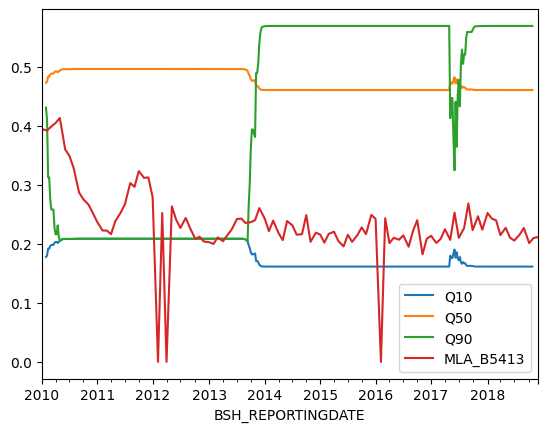

In [36]:
date_idx = list(pred_dates.keys())[:-10]
df_pred = pd.DataFrame(pred[:-10,0,:], index=date_idx)
df_pred.columns = ["Q10", "Q50", "Q90"]
ax = df_pred.plot()
df_real_data = dict_df_y_train['B5413'].copy()
df_real_data['MLA_B5413'] = df_real_data['MLA_B5413']/100
df_real_data.plot(ax=ax)

In [37]:
tft.plot_model()


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
pred, pred_dates = tft.predict(
    X={"W": df_weekly_test, "ME": df_monthly_test},
    y={"ME": dict_df_y_test['B5413']}
)

In [ ]:
df_weekly_test.head(10)